# Refresh data from OneDrive
Data is stored in <br>
`D:\DOMF\Sharepoint\MFP Michelin\guigui perso - Documents\Zoé` <br>
1st step is to copy to <br> 
`D:\git\datacamp-itp\data-scientist-skills\python-sandbox\zoe\data`

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
filename="kilométrage.xlsx"

# importing os module  
import os 
  
# importing shutil module  
import shutil 
  
# path 
path = 'D:\DOMF\Sharepoint\MFP Michelin\guigui perso - Documents\Zoé'
  
# List files and directories 
# in '/home/User/Documents' 
print("Before copying file:") 
print(os.listdir(path)) 
  
  
# Source path 
source = path+"/"+filename
  
# Destination path 
destination = "D:\git\datacamp-itp\data-scientist-skills\python-sandbox\zoe\data/"+filename
  
# Copy the content of 
# source to destination 
dest = shutil.copyfile(source, destination) 
  
# List files and directories 
# in "/home / User / Documents" 
print("After copying file:") 
print(os.listdir(path)) 
  
# Print path of newly  
# created file 
print("Destination path:", dest) 

import datetime
print(datetime.datetime.now())       

Before copying file:
['kilométrage.xlsx']
After copying file:
['kilométrage.xlsx']
Destination path: D:\git\datacamp-itp\data-scientist-skills\python-sandbox\zoe\data/kilométrage.xlsx
2019-10-16 07:56:57.795465


Data should now be in 
[data](data/)

Load kilometrage in dataframe

In [3]:
import pandas as pd
import numpy as np
filename='data/kilométrage.xlsx'
data=pd.read_excel(filename, names=["date", "kms"])
print(data[10:])

         date  kms
10 2019-10-08  284
11 2019-10-09  315
12 2019-10-10  346
13 2019-10-11  386
14 2019-10-12  432
15 2019-10-13  439
16 2019-10-14  439
17 2019-10-15  480
18 2019-10-16  512


Turn date column as a datetime index

In [4]:
data['datetime']=pd.to_datetime(data['date'])
data=data.set_index('datetime')
data.drop(['date'], axis=1, inplace=True)

Créer un range de data entre le 1er jour et aujourd'hui <br>
Remplir les vides avec un pad/ffill (on duplique la derniere valeur connue)

In [5]:
to_date_rng = pd.date_range(start='09/27/2019', end = pd.datetime.today(), freq='D')
#print(to_date_rng)
#print(data.reindex(to_date_rng, method='pad'))
data=data.reindex(to_date_rng, method='pad')

Display various info about our data

In [6]:
print(data.head())
data.info()

            kms
2019-09-27    0
2019-09-28   33
2019-09-29   38
2019-09-30   38
2019-10-01   92
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2019-09-27 to 2019-10-16
Freq: D
Data columns (total 1 columns):
kms    20 non-null int64
dtypes: int64(1)
memory usage: 320.0 bytes


Plot curve : on visualise les kms effectivement faits

C:\Bib\envs\zoe\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


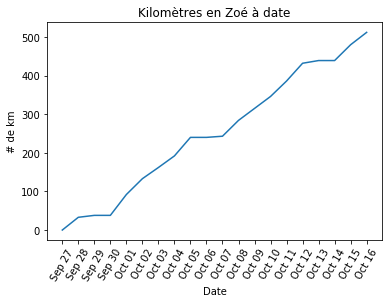

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('# de km')

date_enX=data.index[::1] # tous les 1 jours
labels_date=date_enX.strftime('%b %d') # mois et jour
plt.xticks(date_enX,labels_date,rotation=60)

plt.title('Kilomètres en Zoé à date')

plt.show()

Create a datetime range for 37 months, and a dataset on 37 months

             kms
2019-09-27   0.0
2019-09-28  33.0
2019-09-29  38.0
2019-09-30  38.0
2019-10-01  92.0
...          ...
2022-09-23   NaN
2022-09-24   NaN
2022-09-25   NaN
2022-09-26   NaN
2022-09-27   NaN

[1097 rows x 1 columns]


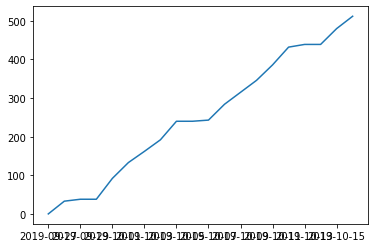

In [8]:
date_rng = pd.date_range(start='09/27/2019', end='09/27/2022', freq='D')
full_data=data.reindex(date_rng)
print(full_data)
plt.plot(full_data)
plt.show()

# Plot data with linear projection
Plot a line between 1st day and today, with a linear projection to last day of lease.

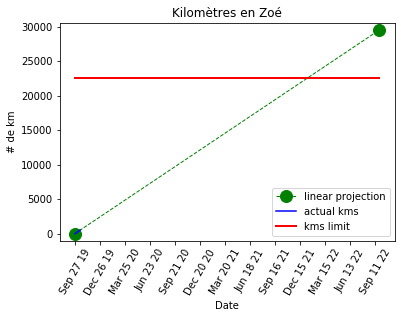

In [9]:
from datetime import date

data_line=data.iloc[[0,-1]] #on garde le 1er point et le dernier point

def get_data_for_linear_projection(intermediate_point):
    d0 = date(2019, 9, 27) #date origine du lease
    d1 = date(2022, 9, 27) #date fin du lease
    d2 = intermediate_point.index[-1].date() #date du 2e point
    delta = d1 - d0 #nbre de jours du contrat
    delta2 = d2 - d0 #nbre de jours à date
    d = pd.DataFrame(0.0, index=np.arange(delta.days+1), columns=['kms'])
    pente = intermediate_point.kms[-1]/delta2.days
    for i in range(delta.days+1):
        kms=i*pente
        d['kms'][i]=kms
    return d

data_line=get_data_for_linear_projection(data_line)
data_line=data_line.set_index(date_rng)

plt.plot([data_line.index[0], data_line.index[-1]], [0,data_line.kms[-1]],color='green', marker='o', linestyle='dashed', linewidth=1, markersize=12, label='linear projection')
plt.plot(full_data, color='blue', label='actual kms')
plt.plot([data_line.index[0], data_line.index[-1]], [22500,22500],color='red',linewidth=2, label='kms limit')
plt.ylim(-1000,max(22500,data_line.kms[-1])+1000)

plt.xlabel('Date')
plt.ylabel('# de km')
plt.legend(loc='lower right')
plt.title('Kilomètres en Zoé')

date_enX=data_line.index[::90] # tous les 90 jours
labels_date=date_enX.strftime('%b %d %y') # mois et jour
plt.xticks(date_enX,labels_date,rotation=60)

plt.show()



## Interpretation of linear projection
Projected kms
if > limit, estimation of extra kms and at which date

In [10]:
print("Projection linéaire sur 37 mois : %3.1f kms."%data_line.kms[-1])
if (data_line.kms[-1] > 22500):
    print("   Dépassement de %3.1f kms commencé le %s." % ((data_line.kms[-1]-22500), data_line[data_line.kms > 22500].index[0].strftime("%d-%b-%Y")))

#trouver à quel date on est à 22500

Projection linéaire sur 37 mois : 29534.3 kms.
   Dépassement de 7034.3 kms commencé le 09-Jan-2022.


# Gradient descent to calculate linear regression

Plot data of actual kms

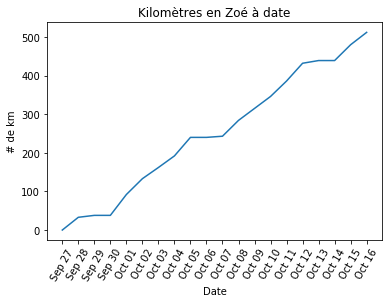

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('# de km')

date_enX=data.index[::1] # tous les 1 jours
labels_date=date_enX.strftime('%b %d') # mois et jour
plt.xticks(date_enX,labels_date,rotation=60)

plt.title('Kilomètres en Zoé à date')

plt.show()

Essayer de faire une animation de type SGD vu dans http://localhost:8889/notebooks/lesson2-sgd.ipynb (fastai lesson 2)

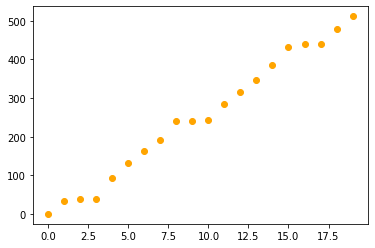

In [12]:
x=(data.index-pd.Timestamp('2019-09-27')).days
y=data.kms.values
plt.scatter(x, y,  c='orange')

m=len(x)

X=np.array([np.ones(m),x])
X=np.transpose(X)
theta=np.zeros((2,1))

# Some gradient descent settings
iterations = 1500;
alpha = 0.01;

## Fonction de coût

In [13]:
def computeCost(X,y,theta):
    m=len(y)
    theta=theta.reshape(2,1)
    y=y.reshape(m,1)
    J=0;
    squareError=np.square(X@theta-y)
    J=np.sum(squareError)/(2*m)
    return(J)
theta=np.zeros((2,1))    
print("Cout: ",theta,computeCost(X,y,theta))
theta=np.array([-1,2])
print("Cout: ",theta,computeCost(X,y,theta))

Cout:  [[0.]
 [0.]] 44517.25
Cout:  [-1  2] 38375.65


## Descente de gradient

In [14]:
from IPython.core.debugger import set_trace

def gradientDescent(X,y,theta,alpha,num_iters):
    m=len(y)
    theta=theta.reshape(2,1)
    y=y.reshape(m,1)
    J_history=np.zeros((num_iters,1))
    for i in range(num_iters):
        newtheta0=theta[0]-alpha*np.sum( (X@theta-y) * X[:,0] ) / m
        newtheta1=theta[1]-alpha*np.sum( (X@theta-y) * X[:,1] ) / m
        theta=np.array([newtheta0, newtheta1]).reshape(2,1)
        J_history[i]=computeCost(X,y,theta)
    return theta, J_history

theta=np.array([-1,2])
alpha=0.001
theta, J_history = gradientDescent(X,y,theta,alpha,iterations)
print(theta, J_history)

[[ 1.56657534]
 [26.38246575]] [[24767.867679  ]
 [18054.18011298]
 [11382.48636049]
 ...
 [  139.85176889]
 [  139.85176889]
 [  139.85176889]]


## Vitesse de convergence SGD

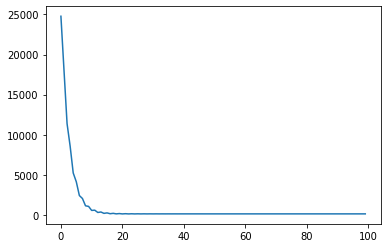

In [15]:
plt.plot(J_history[:100])

## On visualise la regression linéaire

Text(0.5, 1.0, 'Prédiction régression: 28943.1 kms sur 37 mois')

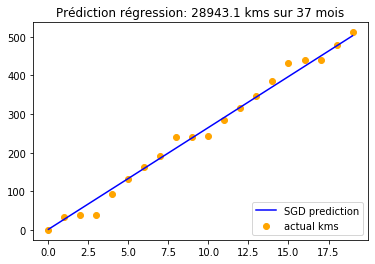

In [16]:
#on caclule les 2 points
x_line=[0,x[-1]]
y_line=[theta[0],theta[0]+theta[1]*x[-1]]
prediction_km=theta[0]+theta[1]*len(data_line)
Title='Prédiction régression: '+np.format_float_positional(prediction_km[0],precision=1)+' kms sur 37 mois'

plt.scatter(x, y,  c='orange', label='actual kms')
plt.plot(x_line, y_line, c='blue', label='SGD prediction')
plt.legend(loc='lower right')
plt.title(Title)


On conserve projection linéaire et régression linéaire.

In [17]:
print(prediction_km[0])
print(data_line.kms[-1])

df_stockage_projection=pd.DataFrame([[data_line.kms[-1],prediction_km[0]]],columns=['Projection','Regression'])
df_stockage_projection['date']=pd.to_datetime('today').replace(hour=0, minute=0, second=0, microsecond=0)
df_stockage_projection=df_stockage_projection.set_index('date')
print(df_stockage_projection.head())
print(df_stockage_projection.info())

28943.131506849306
29534.315789473683
              Projection    Regression
date                                  
2019-10-16  29534.315789  28943.131507
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2019-10-16 to 2019-10-16
Data columns (total 2 columns):
Projection    1 non-null float64
Regression    1 non-null float64
dtypes: float64(2)
memory usage: 24.0 bytes
None


On recharge l'historique des projections linéaire et régressions linéaire.<br>
On ajoute les nouvelles valeurs.

In [18]:
df_historique=pd.read_csv('data/historique_predictions.csv',index_col=0)
df_historique=df_historique.append(df_stockage_projection)
df_historique.index = pd.to_datetime(df_historique.index)
print(df_historique.info())
df_historique.to_csv('data/historique_predictions.csv') 
df_historique

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2019-10-02 to 2019-10-16
Data columns (total 2 columns):
Projection    12 non-null float64
Regression    12 non-null float64
dtypes: float64(2)
memory usage: 288.0 bytes
None


,Projection,Regression
date,,
2019-10-02,29153.600000,21744.379310
2019-10-03,29592.000000,23873.171430
2019-10-04,30061.714290,25380.924530
2019-10-05,32880.000000,27006.627450
2019-10-07,26632.800000,27359.545450
2019-10-08,28296.727270,27537.900000
2019-10-09,28770.000000,27744.893970
2019-10-10,29170.461540,27962.978530
2019-10-11,30218.285710,28274.280000


## On trace les valeurs de projection linéaire et régression, ainsi que la limite.

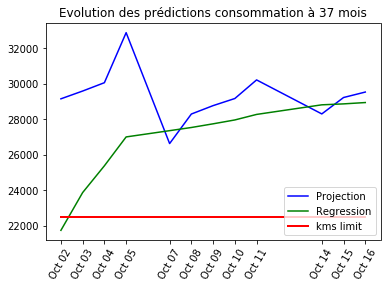

In [19]:
plt.plot(df_historique.index, df_historique.Projection, label='Projection', color='blue')
plt.plot(df_historique.index, df_historique.Regression, label='Regression', color='green')
plt.plot(df_historique.index, 22500*np.ones(len(df_historique.Regression)),color='red',linewidth=2, label='kms limit')

date_enX=df_historique.index[::1] # tous les 1 jours
labels_date=date_enX.strftime('%b %d') # mois et jour
plt.xticks(date_enX,labels_date,rotation=60)

plt.legend(loc='lower right')
plt.title('Evolution des prédictions consommation à 37 mois')
plt.show()